# PandasAI Quickstart Guide

This notebook demonstrates how to get started with PandasAI and how to use it to analyze data through natural language.

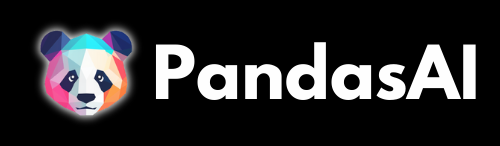


In [ ]:
# Importing the required libraries
import pandas as pd
import pandasai as pai
from pandasai_litellm.litellm import LiteLLM
from sqlalchemy import create_engine
from dotenv import load_dotenv
import os
from IPython.display import Image, display

In [ ]:
# Load environment variables
load_dotenv()

# 1. Getting Familiar with PandasAI
This section will cover the basics of PandasAI, such as loading data and using the .chat() method to talk to it.

## Read Database Directly
For this example, we will load our data directly from our Postgres database using SQLAlquemy 

In [ ]:
# Get values from .env
DB_USER = os.getenv("DB_USER")
DB_PASS = os.getenv("DB_PASSWORD")
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")
DB_NAME = os.getenv("DB_NAME")

In [ ]:
# Create connection to Postgres
engine = create_engine(f"postgresql+psycopg2://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}?sslmode=require")

In [ ]:
# Connect to Postgres
query = "SELECT * FROM users LIMIT 1000;"

# Load data into pandas
database_df = pd.read_sql(query, engine)
print("Data loaded from Postgres")

database_df.head()

## Set up LLM

Use `pandasai_litellm` to select the LLM of your choice and use PandasAI

In [ ]:
# Initialize LiteLLM with an OpenAI model
llm = LiteLLM(model="gpt-4.1-mini")

# Configure PandasAI to use this LLM
pai.config.set({
    "llm": llm
})

## Chat with your data
Now we will use the .chat() method to chat with our data

In [ ]:
# Convert our normal pandas dataframe to a pandasai dataframe
database_df = pai.DataFrame(database_df)

In [ ]:
# Chat with the dataframe
response = database_df.chat("What is the most popular device type per country?")
print(response)

In [ ]:
response = database_df.chat("Plot a bar chart showing the distribution of users per device type")

# Extract the path from ChartResponse object
chart_path = response.path if hasattr(response, 'path') else str(response)

# Display the chart with IPython display
display(Image(filename=chart_path))

In [ ]:
# Chat with the dataframe
response = database_df.chat("[Ask your question here]")
print(response)

## Read Database using PandasAI DB Data Extensions

Now we will learn how to load our data from our Postgres database using the .create() method. This will also create a dataset (locally) which can be reloaded in the future.

In [ ]:
# Create a dataset once from the users table which can be reused anytime.
users_dataset = pai.create(

    # Format: "organization/dataset"
    path="public/users",
    
    # Description of the dataset
    description="Users table from PostgreSQL database",

    # Source of our data (in this case a PostgreSQL table called users)
    source={
        "type": "postgres",
        "connection": {
            "host": DB_HOST,
            "port": 5432,
            "user": DB_USER,
            "password": DB_PASS,
            "database": DB_NAME
        },
        "table": "users"
    }
)

In [ ]:
# Chat with the dataframe
response = users_dataset.chat("What is the most popular device type per country?")
print(response)

## Load Dataset
After creation you load your datasets anytime with the following code

In [ ]:
# Load the dataset we created in the previous step using the .create() method
dataset = pai.load("public/users")

# 2. Using a Semantic Layer in PandasAI
In this section, we will explore how to use a semantic layer in PandasAI in order to improve the accuracy of the AI agent.

## Adding Column Information

In [ ]:
# Create a dataset once from the subscriptions table which can be reused anytime.
subscriptions_dataset = pai.create(

    # Format: "organization/dataset"
    path="public/subscriptions",
    
    # Description of the dataset
    description="Tracks user subscriptions to different plans",

    # Source of our data (in this case a PostgreSQL table called subscriptions)
    source={
        "type": "postgres",
        "connection": {
            "host": DB_HOST,
            "port": 5432,
            "user": DB_USER,
            "password": DB_PASS,
            "database": DB_NAME
        },
        "table": "subscriptions",

        # Define the structure and metadata of your dataset's columns.
        # If not provided, all columns from the input dataframe will be included.
        "columns": [
            {
                "name": "subscription_id",
                "type": "integer",
                "description": "Unique identifier for the subscription"
            },
            {
                "name": "user_id",
                "type": "integer",
                "description": "Foreign key linking to the users table"
            },
            {
                "name": "plan",
                "type": "string",
                "description": "The subscription plan (e.g., free, monthly, annual)"
            },
            {
                "name": "start_date",
                "type": "datetime",
                "description": "Date when the subscription started"
            },
            {
                "name": "end_date",
                "type": "datetime",
                "description": "Date when the subscription ended (if applicable)"
            },
            {
                "name": "status",
                "type": "string",
                "description": "Current status of the subscription (e.g., active, canceled, expired)"
            }
        ]
    }
)

## Enhancing Your Semantic Layer

The semantic layer you just created can be further enhanced with additional features to improve AI accuracy and data understanding:

### What else can you add?

- **Column Expressions**: Define calculated/derived columns using formulas (e.g., `total_revenue = transaction_amount * (1 + tax_rate)`)
- **Column Aliases**: Create alternative names for columns to improve natural language understanding
- **Transformations**: Apply data transformations like anonymization or timezone conversion
- **Group By**: Specify which columns can be used for grouping operations

### How to add them?

These features must be added by **editing the schema.yaml file directly** in `datasets/public/subscriptions/schema.yaml`. 

For example, to add an alias and expression:
```yaml
columns:
  - name: plan
    type: string
    description: The subscription plan
    alias: subscription_plan  # Alternative name
  - name: subscription_length_days
    type: integer
    description: Length of subscription in days
    expression: "EXTRACT(DAY FROM (COALESCE(end_date, CURRENT_DATE) - start_date))"  # Calculated column
```

For detailed documentation on building a comprehensive semantic layer, including examples of expressions, aliases, transformations, and group_by configurations, visit:

📚 **[PandasAI Semantic Layer Documentation](https://docs.pandas-ai.com/v3/semantic-layer/new)**

This will help you create a more powerful and accurate AI agent that better understands your data and business logic.